## GMLS-Nets: 2D Regression of Linear and Non-linear Operators $L[u]$. 

__Ben J. Gross__, __Paul J. Atzberger__ <br>
http://atzberger.org/

Examples showing how GMLS-Nets can be used to perform regression for some basic linear and non-linear differential operators in 2D.  

__Parameters:__</span> <br>
The key parameter terms to adjust are:<br> 
``op_type``: The operator type.<br>
``flag_mlp_case``: The type of mapping unit to use.<br>

__Examples of Non-linear Operators ($u\Delta{u}, u\nabla{u},\nabla{u}\cdot\nabla{u}$) :__<br>
To run training for a non-linear operator like $u\nabla{u}$ using MLP for the non-linear GMLS mapping unit, you can use:<br> 
``op_type=r'u\grad{u}';`` <br>
``flag_mlp_case = 'NonLinear1';`` <br>
You can obtain different performance by adjusting the mapping architecture and hyperparameters of the network.

__Examples of linear Operators ($\nabla{u}, \Delta{u}$):__<br>
To run training for a linear operator like the 1d Laplacian ``uxx`` with a linear mapping unit, you can use<br> 
``op_type=r'\Delta{u}';``<br>
``flag_mlp_case = 'Linear1';``<br>

These are organized for different combinations of these settings allowing for exploring the methods.  The codes are easy to modify and adjust to also experiment with regressing other operators.  For example, see the dataset classes.


In [1]:
import sys;

# setup path to location of gmlsnets_pytorch (if not installed system-wide)
path_gmlsnets_pytorch = '../../';
sys.path.append(path_gmlsnets_pytorch);

import torch;
import torch.nn as nn;

import numpy as np;
import pickle;

import matplotlib.pyplot as plt;

import pdb
import time

import os

# setup gmlsnets package
import gmlsnets_pytorch as gmlsnets;
import gmlsnets_pytorch.nn;
import gmlsnets_pytorch.vis;
import gmlsnets_pytorch.dataset;
import gmlsnets_pytorch.util;

# dereference a few common items
MapToPoly_Function = gmlsnets.nn.MapToPoly_Function;
get_num_polys = MapToPoly_Function.get_num_polys;
weight_one_minus_r = MapToPoly_Function.weight_one_minus_r;
eval_poly = MapToPoly_Function.eval_poly;

print("Packages:");
print("torch.__version__ = " + str(torch.__version__));
print("numpy.__version__ = " + str(np.__version__));
print("gmlsnets.__version__ = " + str(gmlsnets.__version__));

Packages:
torch.__version__ = 1.2.0
numpy.__version__ = 1.16.4
gmlsnets.__version__ = 1.0.0


### Parameters and basic setup

In [2]:
# Setup the parameters
batch_size = int(1e1);
flag_extend_periodic = False; # periodic boundaries
flag_dataset = 'diffOp2';
run_name = '%s_Test1'%flag_dataset;
base_dir = './output/regression_diff_op_2d/%s'%run_name;
flag_save_figs = True;
fig_base_dir = '%s/fig'%base_dir;
flag_print_model = False;

print("Settings:");
print("flag_dataset = " + flag_dataset);
print("run_name = " + run_name);
print("base_dir = " + base_dir);  

if not os.path.exists(base_dir):
  os.makedirs(base_dir);

if not os.path.exists(fig_base_dir):
  os.makedirs(fig_base_dir);

# Configure devices
if torch.cuda.is_available():  
  num_gpus = torch.cuda.device_count();
  print("num_gpus = " + str(num_gpus));
  if num_gpus >= 4:
    device = torch.device('cuda:3');
  else:
    device = torch.device('cuda:0');
else: 
  device = torch.device('cpu');
print("device = " + str(device));           


Settings:
flag_dataset = diffOp2
run_name = diffOp2_Test1
base_dir = ./output/regression_diff_op_2d/diffOp2_Test1
num_gpus = 4
device = cuda:3


## Setup the training and test data

### Input Points

In [3]:
Nx = 21;Ny = 21; 
nx = Nx; ny = Ny;

NNx = 3*Nx; NNy = 3*Ny; # simple periodic by tiling for now
aspect_ratio = NNx/float(NNy);
xx = np.linspace(-1.5,aspect_ratio*1.5,NNx); xx = xx.astype(float);
yy = np.linspace(-1.5,1.5,NNy); yy = yy.astype(float);

aa = np.meshgrid(xx,yy);
np_xj = np.array([aa[0].flatten(), aa[1].flatten()]).T;

aa = np.meshgrid(xx,yy);
np_xi = np.array([aa[0].flatten(), aa[1].flatten()]).T;

# make torch tensors
xj = torch.from_numpy(np_xj).float().to(device); # convert to torch tensors
xj.requires_grad = False;

xi = torch.from_numpy(np_xi).float().to(device); # convert to torch tensors
xi.requires_grad = False;    

### Generate the Dataset

In [4]:
if flag_dataset == 'diffOp2':
  
  flag_verbose = 1;
  #op_type = r'\Delta{u}';op_type = r'\Delta{u}*\Delta{u}';
  #op_type = r'u\Delta{u}';op_type = r'\grad{u}';op_type = r'u\grad{u}';
  #op_type = r'\grad{u}\cdot\grad{u}';
  op_type = r'u\grad{u}';
    
  num_dim = 2;
  num_training_samples = int(5e3);
  nchannels_u = 1;  
  Nc = nchannels_u;

  #alpha1 = 0.05;
  alpha1 = 0.3;
  scale_factor = 1e2;
  train_dataset = gmlsnets.dataset.diffOp2(op_type=op_type,op_params=None,
                                           gen_mode='exp1',gen_params={'alpha1':alpha1},
                                           num_samples=num_training_samples,
                                           nchannels=nchannels_u,nx=nx,ny=ny,
                                           noise_factor=0,scale_factor=scale_factor,
                                           flag_verbose=flag_verbose);
  
  train_dataset = train_dataset.to(device);
  if flag_verbose > 0:
    print("done.");

  num_test_samples = int(1e3);
  scale_factor = 1e2;
  test_dataset = gmlsnets.dataset.diffOp2(op_type=op_type,op_params=None,
                                          gen_mode='exp1',gen_params={'alpha1':alpha1},
                                          num_samples=num_test_samples,
                                          nchannels=nchannels_u,nx=nx,ny=ny,
                                          noise_factor=0,scale_factor=scale_factor,
                                          flag_verbose=flag_verbose);
  test_dataset = test_dataset.to(device);
    
  if flag_verbose > 0:
    print("done.");
  
else:
  msg = "flag_dataset not recognized.";
  msg += "flag_dataset = " + str(flag_dataset);
  raise Exception(msg);

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True);
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=False);

# Cound number of output channels in f, determines if scalar or vector valued data
nchannels_f = train_dataset.samples_Y.shape[1];

Generating the data samples which can take some time.
num_samples = 5000
done.
Generating the data samples which can take some time.
num_samples = 1000
done.


## Show Data

saveFilename = ./output/regression_diff_op_2d/diffOp2_Test1/fig/samples_u.pdf
saveFilename = ./output/regression_diff_op_2d/diffOp2_Test1/fig/samples_u.png
saveFilename = ./output/regression_diff_op_2d/diffOp2_Test1/fig/samples_f.pdf
saveFilename = ./output/regression_diff_op_2d/diffOp2_Test1/fig/samples_f.png


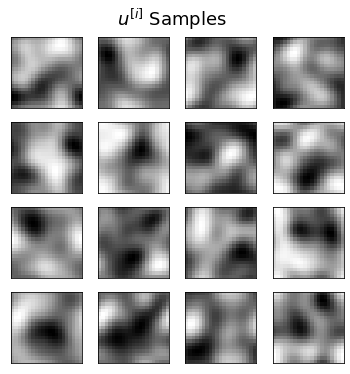

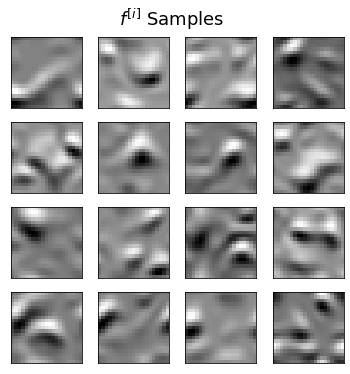

In [5]:
flag_run_cell = True;
if flag_run_cell:
    # Show subset of the data 
    img_arr = [];
    label_str_arr = [];

    numImages = len(train_dataset);
    #II = np.random.permutation(numImages); # compute random collection of indices @optimize
    II = np.arange(numImages);

    if flag_dataset == '' or 0 == 0:          
      img_arr = [];
      channelI = 0; # for vector-valued fields, choose component.
      for I in np.arange(0,min(num_training_samples,16)):        
        img_arr.append(train_dataset[II[I],channelI,:][0].cpu());
      gmlsnets.vis.plot_image_array(img_arr,title=r'$u^{[i]}$ Samples',figSize=(6,6),title_yp=0.95);
    
      if flag_save_figs:
        fig_name = 'samples_u';
        gmlsnets.vis.save_fig('%s/%s'%(fig_base_dir,fig_name),'',flag_verbose=True,dpi_set=200,flag_pdf=True);
        
      img_arr = [];
      channelI = 0;
      for I in np.arange(0,min(num_training_samples,16)):
        img_arr.append(train_dataset[II[I],channelI,:][1].cpu());      
      gmlsnets.vis.plot_image_array(img_arr,title=r'$f^{[i]}$ Samples',figSize=(6,6),title_yp=0.95);
    
      if flag_save_figs:
        fig_name = 'samples_f';
        gmlsnets.vis.save_fig('%s/%s'%(fig_base_dir,fig_name),'',flag_verbose=True,dpi_set=200,flag_pdf=True);
      
        

### Side-by-Side View

saveFilename = ./output/regression_diff_op_2d/diffOp2_Test1/fig/samples_u_f_Ic_f_0.pdf
saveFilename = ./output/regression_diff_op_2d/diffOp2_Test1/fig/samples_u_f_Ic_f_0.png
saveFilename = ./output/regression_diff_op_2d/diffOp2_Test1/fig/samples_u_f_Ic_f_1.pdf
saveFilename = ./output/regression_diff_op_2d/diffOp2_Test1/fig/samples_u_f_Ic_f_1.png


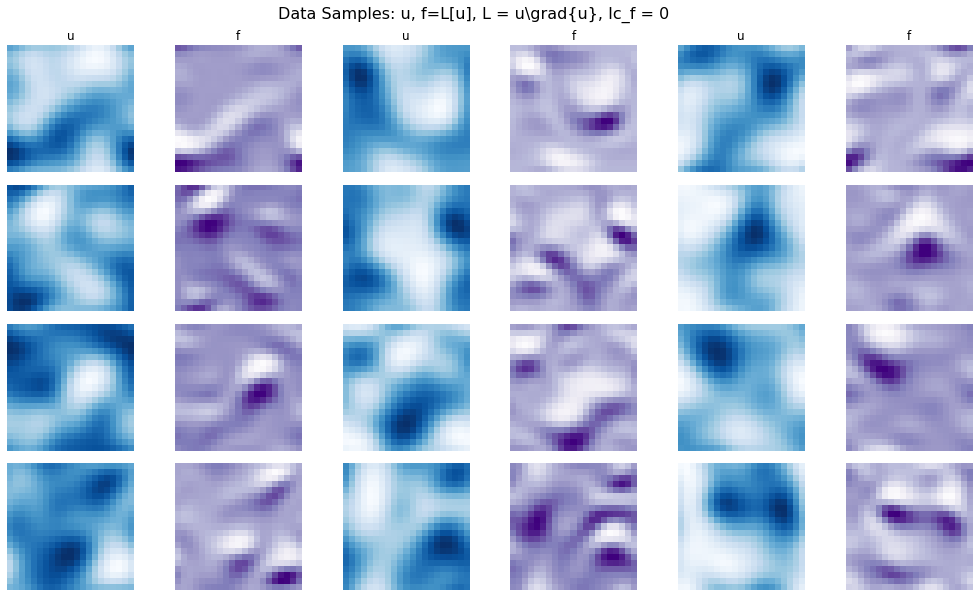

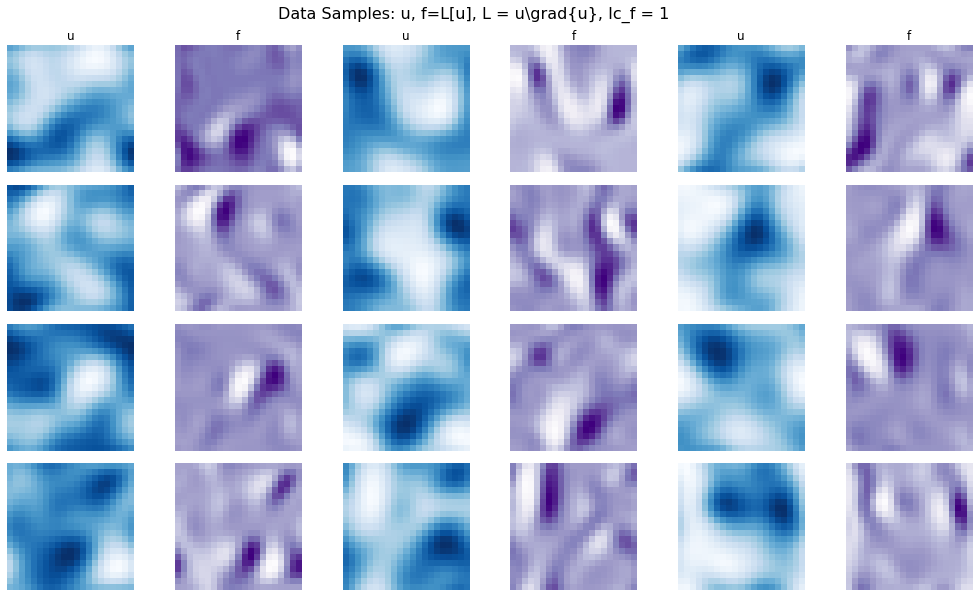

In [6]:
%matplotlib inline

for Ic_f in range(0,nchannels_f):
  # plot sample of the training data
  gmlsnets.vis.plot_dataset_diffOp2(train_dataset,np_xj,np_xi,rows=4,cols=6,channelI_f=Ic_f,
                                    title="Data Samples: u, f=L[u], L = %s, Ic_f = %d"%(op_type,Ic_f));

  if flag_save_figs:
    fig_name = 'samples_u_f_Ic_f_%d'%Ic_f;
    gmlsnets.vis.save_fig('%s/%s'%(fig_base_dir,fig_name),'',flag_verbose=True,dpi_set=200,flag_pdf=True);

### Setup GMLS-Net for regressing differential operator

In [7]:
class gmlsNetRegressionDiffOp2(nn.Module):
    """Sets up a GMLS-Net for regression differential operator in 2D."""    
    def __init__(self,
                 flag_GMLS_type=None, 
                 porder1=None,Nx=None,Ny=None,Nc=None,pts_x1=None,layer1_epsilon=None, 
                 weight_func1=None,weight_func1_params=None, 
                 mlp_q1=None,pts_x2=None,
                 device=None,flag_verbose=0,
                 **extra_params):

        super(gmlsNetRegressionDiffOp2, self).__init__();

        # setup the layers
        self.layer_types = [];

        if device is None:
          device = torch.device('cpu');  # default 

        # --
        Ncp1 = mlp_q1.channels_out; # number of channels out of the MLP-Pointwise layer
                                
        num_features1 = mlp_q1.channels_out;  # number of channels out 
        
        GMLS_Layer = gmlsnets.nn.GMLS_Layer;
        ExtractFromTuple = gmlsnets.nn.ExtractFromTuple;
        PermuteLayer = gmlsnets.nn.PermuteLayer;
        ReshapeLayer = gmlsnets.nn.ReshapeLayer;
        PdbSetTraceLayer = gmlsnets.nn.PdbSetTraceLayer;
        
        PeriodicPad2d = gmlsnets.util.PeriodicPad2d;
        ExtractUnitCell2d = gmlsnets.util.ExtractUnitCell2d;

        # --- Layer 1
        #flag_layer1 = 'standard_conv1';
        flag_layer1 = 'gmls2d_1';
        self.layer_types.append(flag_layer1);
        if flag_layer1 == 'standard_conv1':
          self.layer1 = nn.Sequential(
               PeriodicPad2d(), # expands width by 3
               nn.Conv2d(in_channels=Nc,out_channels=num_features1,
                         kernel_size=5,stride=1,padding=2,bias=False),
               ExtractUnitCell2d()               
               ).to(device);
        elif flag_layer1 == 'gmls2d_1':
          NNx = 3*Nx; NNy = 3*Ny; # periodic extensions
          reshape_ucell_to_GMLS_data = (-1,Nc,NNx*NNy); # map from assumed (batch,Nc,Nx,Ny) --> (batch,Nc,Nx*Ny)
          permute_ucell_to_GMLS_data = None; # identity map
        
          permute_pre_GMLS_data_to_ucell = (0,2,1); # maps (batch,Nx*Ny,Ncp) --> (batch,Ncp,Nx*Ny)
        
          reshape_GMLS_data_to_ucell = (-1,Ncp1,NNx,NNy); # maps to (batch,Ncp,Nx,Ny), Ncp new channels
          permute_GMLS_data_to_ucell = None; # identity map      
                                                  
          self.layer1 = nn.Sequential(
               PeriodicPad2d(), # expands 2D unit cell perodically with width by x3
               ReshapeLayer(reshape_ucell_to_GMLS_data, permute_ucell_to_GMLS_data), # reshape for GMLS-Net
               #PdbSetTraceLayer(),
               GMLS_Layer(flag_GMLS_type, porder1,
                          pts_x1, layer1_epsilon,
                          weight_func1, weight_func1_params,
                          mlp_q=mlp_q1, pts_x2=pts_x2, device=device,
                          flag_verbose=flag_verbose),
               #PdbSetTraceLayer(),
               ExtractFromTuple(index=0), # just get the forward output associated with the mapping and not pts_x2           
               PermuteLayer(permute_pre_GMLS_data_to_ucell),
               ReshapeLayer(reshape_GMLS_data_to_ucell, permute_GMLS_data_to_ucell), # reshape the data out of GMLS                
               #PdbSetTraceLayer(),               
               ExtractUnitCell2d()
               ).to(device);
            
        else:
          raise Exception('The flag_layer1 type was not recognized.');
        
    def forward(self, x):        
        out = self.layer1(x);                
        return out;

### Setup the Model: Neural Network

In [8]:
# setup parameters
porder = 2; num_polys = get_num_polys(porder,num_dim);

weight_func1 = MapToPoly_Function.weight_one_minus_r;
targ_kernel_width = 1.5; layer1_epsilon = 1.1*0.5*np.sqrt(2)*targ_kernel_width/Nx; 
weight_func1_params = {'epsilon': layer1_epsilon,'p':4};

#color_input = (0.05,0.44,0.69);
#color_output = (0.44,0.30,0.60);
#color_predict = (0.05,0.40,0.5);
#color_target = (221/255,103/255,103/255);

# print the current settings
print("GMLS Parameters:")
print("porder = " + str(porder));
print("num_polys = " + str(num_polys));
print("layer1_epsilon = %.3e"%layer1_epsilon);
print("weight_func1 = " + str(weight_func1));
print("weight_func1_params = " + str(weight_func1_params));
print("num_dim = " + str(num_dim));
print("Nx = %d, Ny = %d, Nc = %d"%(Nx,Ny,Nc));
print("xj.shape = " + str(xj.shape));
print("xi.shape = " + str(xi.shape));

GMLS Parameters:
porder = 2
num_polys = 6
layer1_epsilon = 5.556e-02
weight_func1 = <function MapToPoly_Function.weight_one_minus_r at 0x7f15f5e610e0>
weight_func1_params = {'epsilon': 0.0555583899503716, 'p': 4}
num_dim = 2
Nx = 21, Ny = 21, Nc = 1
xj.shape = torch.Size([3969, 2])
xi.shape = torch.Size([3969, 2])


In [9]:
# create an MLP for training the non-linear part of the GMLS Net
num_polys = get_num_polys(porder,num_dim);

print("num_dim = " + str(num_dim));
print("num_polys = " + str(num_polys));
print("Nx = " + str(Nx) + " Ny = " + str(Ny));
print("NNx = " + str(NNx) + " NNy = " + str(NNy));
print("nchannels_f = " + str(nchannels_f));

print("");

#flag_mlp_case = 'Linear1';flag_mlp_case = 'Nonlinear1';
flag_mlp_case = 'Nonlinear1';

if (flag_mlp_case == 'Linear1'):

  # -- Layer 1    
  layer_sizes  = [];

  num_depth    = 0; # number of internal depth
  num_hidden   = -1;

  channels_in  = Nc; # number of poly channels for input
  #channels_out = 16; # number of output filters [might want to decouple by using separate weights here] 
  channels_out = nchannels_f; # number of output filters, (scalar=1, vector=2,3,...)
  Nc2          = channels_out;

  layer_sizes.append(num_polys);
  for k in range(num_depth):
    layer_sizes.append(num_hidden);
  layer_sizes.append(1); # for single unit always give scalar output, we then use channels_out units.

  mlp_q1 = gmlsnets.nn.MLP_Pointwise(layer_sizes,
                                     channels_in=channels_in,
                                     channels_out=channels_out,
                                     flag_bias=False);
  mlp_q1.to(device);

elif (flag_mlp_case == 'Nonlinear1'):
  layer_sizes = [];
  num_input   = Nc*num_polys; # number of channels*num_polys (cross-channel coupling allowed)
  #num_depth   = 4; # number of internal depth
  num_depth   = 1; # number of internal depth
  num_hidden  = 500; 
  num_out_channels = nchannels_f; # number of output filters, (scalar=1, vector=2,3,...)
  layer_sizes.append(num_polys);
  for k in range(num_depth):
    layer_sizes.append(num_hidden);
  layer_sizes.append(1); # for single unit always give scalar output, we then use channels_out units.
  #layer_sizes.append(num_out_channels);

  #mlp_q = gmlsnets.nn.atzGMLS_MLP1_Module(layer_sizes);
  mlp_q1 = gmlsnets.nn.MLP_Pointwise(layer_sizes,channels_out=num_out_channels);
  mlp_q1.to(device);

if flag_print_model:
  print("mlp_q1:");
  print(mlp_q1);

num_dim = 2
num_polys = 6
Nx = 21 Ny = 21
NNx = 63 NNy = 63
nchannels_f = 2



In [10]:
# Setup the Neural Network for Regression
flag_verbose = 0;
flag_case = 'standard';

# Setup the model
model = gmlsNetRegressionDiffOp2(flag_case,porder,Nx,Ny,Nc,xj,layer1_epsilon,
                                 weight_func1,weight_func1_params,
                                 mlp_q1=mlp_q1,pts_x2=xi,
                                 device=device, 
                                 flag_verbose=flag_verbose);

if flag_print_model:
  print("model:");
  print(model);

## Train the Model

### Custom Functions

In [11]:
def custom_loss_least_squares(val1,val2):  
  r"""Computes the Mean-Square-Error (MSE) over the entire batch."""
  diff_flat = (val1 - val2).flatten();
  N = diff_flat.shape[0];
  loss = torch.sum(torch.pow(diff_flat,2),-1)/N;
  return loss;

### Initialize

In [12]:
# setup one-time data structures
loss_list = np.empty(0); loss_step_list = np.empty(0);
save_skip = 1; step_count = 0;

### Train the network.

In [13]:
num_epochs    = int(2e0);
learning_rate = 1e-1;

print("Training the model with:");

print("model:");
print("model.layer_types = " + str(model.layer_types));
print("");

# setup the optimization method and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate);

loss_func = custom_loss_least_squares;

print("num_epochs = %d"%num_epochs);
print("batch_size = %d"%batch_size);
print(" ");

# Train the model
flag_time_it = True;
if flag_time_it:
  time_1 = time.time();

numSteps = len(train_loader);
for epoch in range(num_epochs):
    for i, (input,target) in enumerate(train_loader):     
    #if 1 == 1:
        input  = input.to(device);
        target = target.to(device);

        # Compute model
        output = model(input);

        # Compute loss
        loss = loss_func(output,target);

        # Display
        if step_count % save_skip == 0:
          np_loss   = loss.cpu().detach().numpy();
          loss_list = np.append(loss_list,np_loss);
          loss_step_list = np.append(loss_step_list,step_count);
        
        # Backward and optimize
        optimizer.zero_grad();                
        loss.backward();
        
        #for p in model.parameters():
        #  print(p.grad);
        
        optimizer.step();
        
        step_count += 1;
        
        if ((i + 1) % 100) == 0 or i == 0:
        #if ((step_count + 1) % int(1e3)) == 0 or step_count == 0:        
          #print("WARNING: Debug mode...");
          msg = 'epoch: [%d/%d]; '%(epoch+1,num_epochs);
          msg += 'batch_step = [%d/%d]; '%(i + 1,numSteps);
          msg += 'loss_MSE: %.3e.'%(loss.item());
          print(msg);
            
          if flag_time_it and i > 0:
            msg = 'elapsed_time = %.1e secs \n'%(time.time() - time_1);            
            print(msg);
            time_1 = time.time();
            
print("done.");

Training the model with:
model:
model.layer_types = ['gmls2d_1']

num_epochs = 2
batch_size = 10
 
epoch: [1/2]; batch_step = [1/500]; loss_MSE: 4.314e+00.
epoch: [1/2]; batch_step = [100/500]; loss_MSE: 4.494e-01.
elapsed_time = 5.0e+00 secs 

epoch: [1/2]; batch_step = [200/500]; loss_MSE: 1.245e-01.
elapsed_time = 4.7e+00 secs 

epoch: [1/2]; batch_step = [300/500]; loss_MSE: 8.643e-02.
elapsed_time = 5.0e+00 secs 

epoch: [1/2]; batch_step = [400/500]; loss_MSE: 1.129e-01.
elapsed_time = 5.0e+00 secs 

epoch: [1/2]; batch_step = [500/500]; loss_MSE: 1.170e-01.
elapsed_time = 5.1e+00 secs 

epoch: [2/2]; batch_step = [1/500]; loss_MSE: 1.421e-01.
epoch: [2/2]; batch_step = [100/500]; loss_MSE: 1.320e-01.
elapsed_time = 5.1e+00 secs 

epoch: [2/2]; batch_step = [200/500]; loss_MSE: 2.291e+00.
elapsed_time = 5.0e+00 secs 

epoch: [2/2]; batch_step = [300/500]; loss_MSE: 9.599e-02.
elapsed_time = 5.0e+00 secs 

epoch: [2/2]; batch_step = [400/500]; loss_MSE: 7.363e-02.
elapsed_time = 5

### Plot Loss

saveFilename = ./output/regression_diff_op_2d/diffOp2_Test1/fig/training_loss.pdf
saveFilename = ./output/regression_diff_op_2d/diffOp2_Test1/fig/training_loss.png


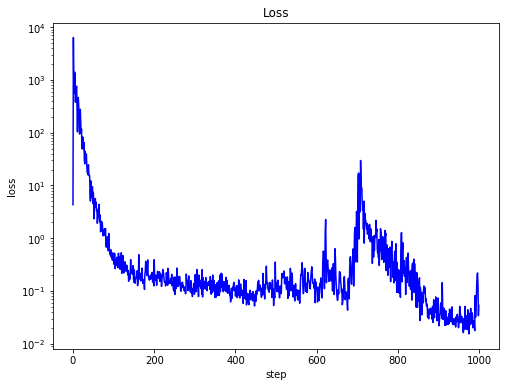

In [14]:
%matplotlib inline

plt.figure(figsize=(8,6));

plt.plot(loss_step_list,loss_list,'b-');
plt.yscale('log');
plt.xlabel('step');
plt.ylabel('loss');

plt.title('Loss');

if flag_save_figs:
  fig_name = 'training_loss';
  gmlsnets.vis.save_fig('%s/%s'%(fig_base_dir,fig_name),'',flag_verbose=True,dpi_set=200,flag_pdf=True);

### Test the Neural Network Predictions 

In [15]:
print("Testing predictions of the neural network:");

flag_save_tests = True;
if flag_save_tests:
  test_data = {};

# Save the first few to show as examples of labeling
saved_test_input = [];
saved_test_target = [];
saved_test_output_pred = [];

count_batch = 0;
with torch.no_grad():    
    total = 0; II = 0;
    avg_error = 0;
    for input,target in test_loader: # loads data in batches and then sums up

        if (II >= 1000):
          print("tested on %d samples"%total);
          II = 0;

        input = input.to(device); target = target.to(device);        
        
        # Compute model        
        output = model(input);        

        # Compute loss
        loss = loss_func(output,target);

        # Record the results
        avg_error += loss;       

        total += output.shape[0];        
        II += output.shape[0];
        count_batch += 1;

    NN = output.shape[0];        
    for k in range(min(NN,20)): # save first 10 images of each batch          
      saved_test_input.append(input[k]); 
      saved_test_target.append(target[k]);
      saved_test_output_pred.append(output[k]);
        
    print("");
    print("Tested on a total of %d samples."%total);    
    print("");
    
    # Compute RMSD error
    test_accuracy = avg_error.cpu()/count_batch;
    test_accuracy = np.sqrt(test_accuracy); 
            
    print("The neural network has RMSD error %.2e on the %d test samples."%(test_accuracy,total));
    print("");


Testing predictions of the neural network:

Tested on a total of 1000 samples.

The neural network has RMSD error 3.28e-01 on the 1000 test samples.



### Show a Sample of the Predictions 

num_prediction_samples = 10
saveFilename = ./output/regression_diff_op_2d/diffOp2_Test1/fig/predictions_Ic_f_0.pdf
saveFilename = ./output/regression_diff_op_2d/diffOp2_Test1/fig/predictions_Ic_f_0.png
saveFilename = ./output/regression_diff_op_2d/diffOp2_Test1/fig/predictions_Ic_f_1.pdf
saveFilename = ./output/regression_diff_op_2d/diffOp2_Test1/fig/predictions_Ic_f_1.png


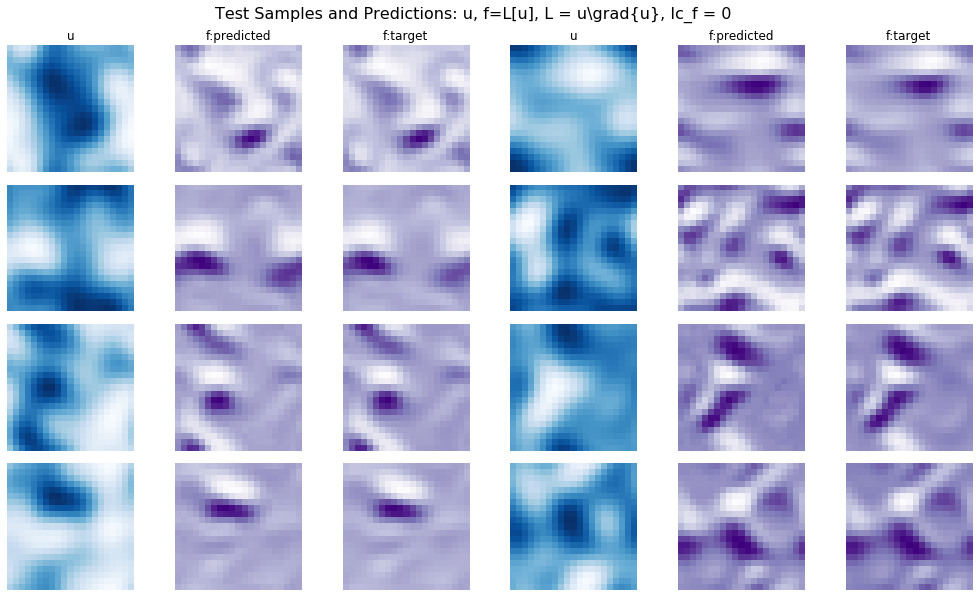

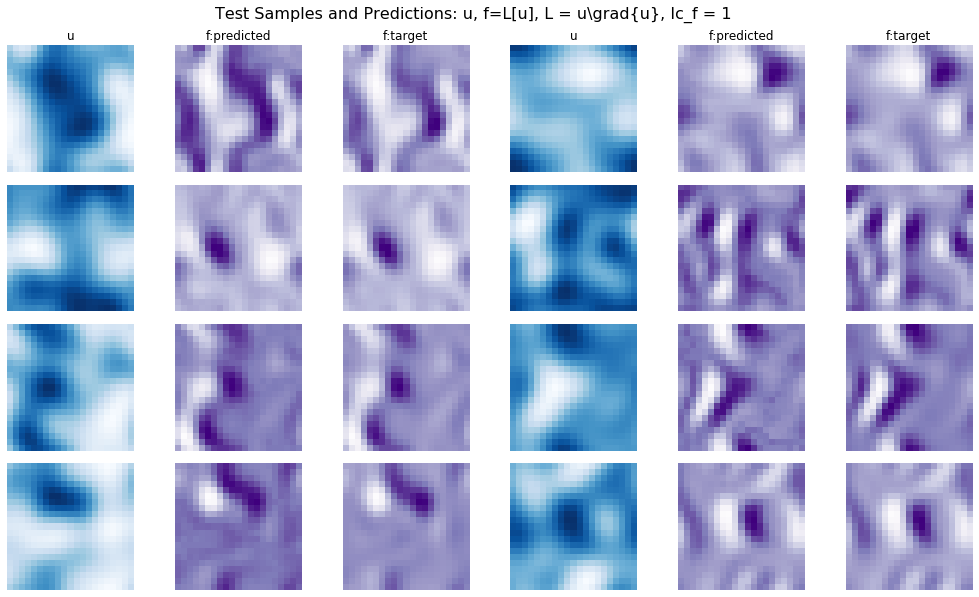

In [16]:
# collect a subset of the data to show and attach named labels
%matplotlib inline

num_prediction_samples = len(saved_test_input);
print("num_prediction_samples = " + str(num_prediction_samples));

#II = np.random.permutation(num_samples); # compute random collection of indices @optimize
II = np.arange(num_prediction_samples);

if flag_dataset == 'name-here' or 0 == 0:        
  u_list = []; f_target_list = []; f_pred_list = [];  
  for I in np.arange(0,min(num_prediction_samples,16)):        
    u_list.append(saved_test_input[II[I]].cpu());
    f_target_list.append(saved_test_target[II[I]].cpu());
    f_pred_list.append(saved_test_output_pred[II[I]].cpu());

# plot predictions against test data
for Ic_f in range(0,nchannels_f):
  title = "Test Samples and Predictions: u, f=L[u], L = %s, Ic_f = %d"%(op_type,Ic_f);
  gmlsnets.vis.plot_samples_u_f_fp_2d(u_list,f_target_list,f_pred_list,np_xj,np_xi,
                                      channelI_f=Ic_f,rows=4,cols=6,
                                      title=title);

  if flag_save_figs:
    fig_name = 'predictions_Ic_f_%d'%Ic_f;
    gmlsnets.vis.save_fig('%s/%s'%(fig_base_dir,fig_name),'',flag_verbose=True,dpi_set=200,flag_pdf=True);

### Save Model

In [17]:
model_filename = '%s/model.ckpt'%base_dir;
print("model_filename = " + model_filename);
torch.save(model.state_dict(), model_filename);

model_filename = "%s/model_state.pickle"%base_dir;
print("model_filename = " + model_filename);
f = open(model_filename,'wb');
pickle.dump(model.state_dict(),f);
f.close();


model_filename = ./output/regression_diff_op_2d/diffOp2_Test1/model.ckpt
model_filename = ./output/regression_diff_op_2d/diffOp2_Test1/model_state.pickle


### Display the GMLS-Nets Learned Parameters

In [18]:
flag_run_cell = flag_print_model;

if flag_run_cell:
  print("-"*80)      
  print("model.parameters():");
  ll = model.parameters();
  for l in ll:
    print(l);    
  
if flag_run_cell:
  print("-"*80)        
  print("model.state_dict():");  
  print(model.state_dict());
  print("-"*80)    

### Done